In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import src.fitting as fitting
import src.multielec_utils as mutils
import statsmodels.api as sm
import jax
import jax.numpy as jnp
from scipy.io import savemat, loadmat
import optax
from matplotlib import cm
from copy import copy

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def activation_probs(x, w):
    # w : site weights, n x d
    # x : current levels, c x d
    site_activations = jnp.dot(w, jnp.transpose(x)) # dimensions: n x c
    p_sites = jax.nn.sigmoid(site_activations) # dimensions : n x c
    p = 1 - jnp.prod(1 - p_sites, 0)  # dimensions: c

    return p

In [3]:
def neg_log_likelihood(w, x, y, trials, l2_reg=0):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # trials: number of trials at each current level, c
    # l2_reg: l2 regularization penalty
    
    p_model = activation_probs(x, w) # dimensions: c
    p_model = jnp.clip(p_model, a_min=1e-5, a_max=1-1e-5)

    trials = trials.astype(int)
    
    nll = -jnp.sum(trials * y * jnp.log(p_model) + trials * (1 - y) * jnp.log(1 - p_model))

    penalty = l2_reg/2 * jnp.linalg.norm(w)**2

    return nll + penalty

In [4]:
def optimize_w(w, x, y, trials, l2_reg=0, zero_prob=0.01, step_size=0.0001, n_steps=100, wtol=5e-5, step_cnt_decrement=5):

    m = len(w)
    z = 1 - (1 - zero_prob)**(1/m)

    optimizer = optax.adamw(step_size)
    opt_state = optimizer.init(w)

    @jax.jit
    def update(w, x, y, trials, l2_reg):
        grads = jax.grad(neg_log_likelihood)(w, x, y, trials, l2_reg=l2_reg)
        return grads

    losses = []
    prev_w = w
    for step in range(n_steps):
        grads = update(w, x, y, trials, l2_reg)
        updates, opt_state = optimizer.update(grads, opt_state, params=w)
        w = optax.apply_updates(w, updates)

        losses += [neg_log_likelihood(w, x, y, trials, l2_reg=l2_reg)]
        w = w.at[:, 0].set(jnp.minimum(w[:, 0], np.log(z/(1-z))))

        if jnp.linalg.norm(w - prev_w) / len(w.ravel()) <= wtol:
            break
        prev_w = w
        
    return losses, w

In [5]:
def fit_surface_McF(x, y, trials, w_inits, R2_thresh=0.02, l2_reg=0.01, w_step_size=0.001, n_steps=3500, plot=False, random_state=None):
    
    ybar = jnp.sum(y * trials) / jnp.sum(trials)
    beta_null = jnp.log(ybar / (1 - ybar))
    null_weights = jnp.concatenate((jnp.array([beta_null]), jnp.zeros(x.shape[-1]-1)))
    nll_null = neg_log_likelihood(null_weights, x, y, trials, l2_reg=l2_reg)
    print(nll_null)
    
    losses, w_final = optimize_w(w_inits[0], x, y, trials, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)
    last_opt = w_final
    last_R2 = 1 - losses[-1] / nll_null
    w_inits[0] = w_final
    print(last_R2, losses[-1])

    if plot:
        p_pred_all = activation_probs(X_all, w_final)
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_all[:, 1], 
                    X_all[:, 2],
                    X_all[:, 3], marker='o', c=p_pred_all, s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        plt.figure()
        plt.plot(losses)
        plt.show()

    for i in range(1, len(w_inits)):
        losses, w_final = optimize_w(w_inits[i], x, y, trials, l2_reg=l2_reg, step_size=w_step_size, n_steps=n_steps)
        w_inits[i] = w_final

        if plot:
            p_pred_all = activation_probs(X_all, w_final)
            fig = plt.figure()
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(X_all[:, 1], 
                        X_all[:, 2],
                        X_all[:, 3], marker='o', c=p_pred_all, s=20, alpha=0.8, vmin=0, vmax=1)

            plt.show()

            plt.figure()
            plt.plot(losses)
            plt.show()

        new_opt = w_final
        new_R2 = 1 - losses[-1] / nll_null
        print(new_R2, losses[-1])
        if new_R2 - last_R2 <= R2_thresh:
            break

        last_opt = new_opt
        last_R2 = new_R2

    w_final = last_opt
    
    if plot:
        p_pred_all = activation_probs(X_all, w_final)
        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        scat = ax.scatter(X_all[:, 1], 
                    X_all[:, 2],
                    X_all[:, 3], marker='o', c=p_pred_all, s=20, alpha=0.8, vmin=0, vmax=1)

        plt.show()

        # fig = plt.figure()
        # fig.clear()
        # ax = Axes3D(fig, auto_add_to_figure=False)
        # fig.add_axes(ax)
        # plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        # plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        # plt.xlim(-1.8, 1.8)
        # plt.ylim(-1.8, 1.8)
        # ax.set_zlim(-1.8, 1.8)
        # ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X[:, 1], 
        #             X[:, 2],
        #             X[:, 3], marker='o', c=probs, s=20, alpha=0.8, vmin=0, vmax=1)

        # plt.show()

    return w_final, w_inits

368312.28
0.9474658 19349.0


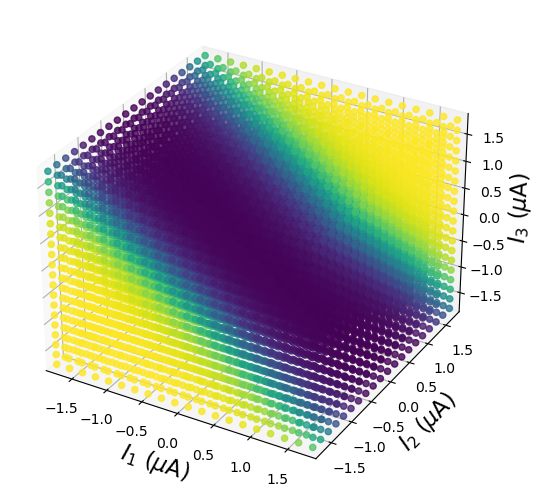

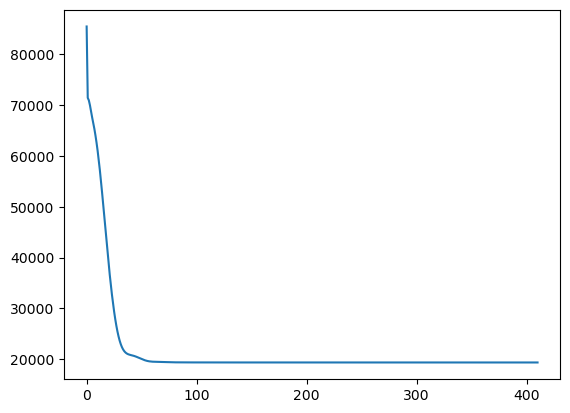

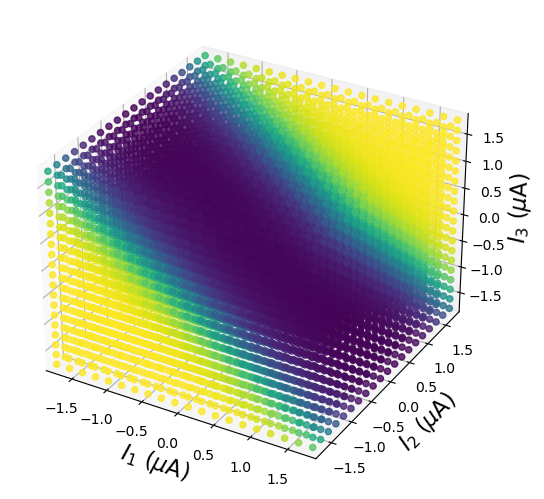

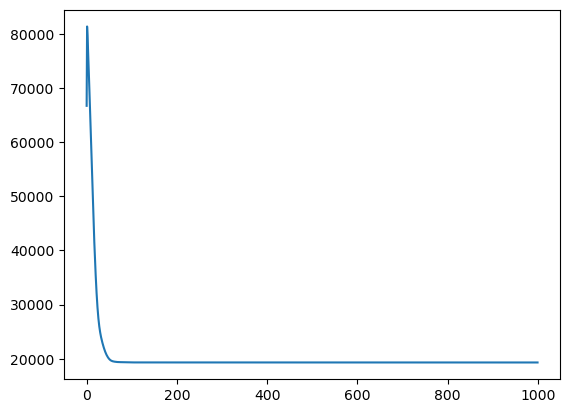

0.9475673 19311.605


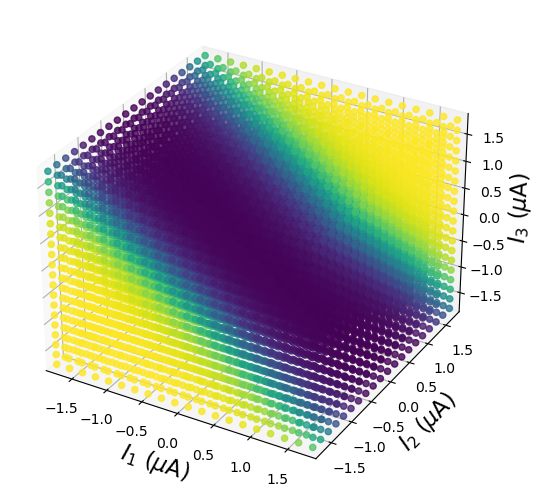

In [8]:
# Path definitions
ANALYSIS_BASE = "/Volumes/Analysis"
MATFILE_BASE = "/Volumes/Scratch/Users/praful/triplet_gsort_matfiles_20220420"
gsort_path = None

dataset = "2020-10-06-7"
estim = "data003/data003-all"
wnoise = "kilosort_data000/data000"
electrical_path = os.path.join(ANALYSIS_BASE, dataset, estim)
vis_datapath = os.path.join(ANALYSIS_BASE, dataset, wnoise)

ms = [2, 3, 4, 5]
l2_reg = 0
w_step_size = 0.1
# folds = 5
n_steps = 1000
# train_size = 0.8

# method = 'L-BFGS-B'
# jac = fitting.negLL_hotspot_jac
# l2_reg = 0.1
R2_thresh = 0.002

p = 3
cell = 296

X_expt_orig, probs_orig, T_orig = mutils.loadNewLVData(electrical_path, gsort_path, dataset, estim, wnoise, p, cell,
                                        load_from_mat=True, 
                                        MATFILE_BASE=MATFILE_BASE)
X_all = jnp.array(sm.add_constant(mutils.get_stim_amps_newlv(electrical_path, p), has_constant='add'))
X_expt, probs, T = mutils.triplet_cleaning(X_expt_orig, probs_orig, T_orig, electrical_path, p)
X = jnp.array(sm.add_constant(X_expt, has_constant='add'))
probs = jnp.array(probs)
T = jnp.array(T, dtype=int)

w_inits = []
for m in ms:
    w_init = jnp.array(np.random.normal(size=(m, X.shape[1])))
    w_inits.append(w_init)
    
w_true, _ =  fit_surface_McF(X, probs, T, w_inits, R2_thresh=R2_thresh, l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=True)

In [9]:
print(w_true)
X_expt_orig = mutils.get_stim_amps_newlv(electrical_path, p)
p_true = activation_probs(jnp.array(sm.add_constant(X_expt_orig, has_constant='add')), w_true) # prob with each current level
X = jnp.array(sm.add_constant(X_expt_orig, has_constant='add'))

[[-5.656018   2.4329286  3.2199075  2.7438898]
 [-5.6420155 -2.5601647 -3.4831784 -2.8054042]]


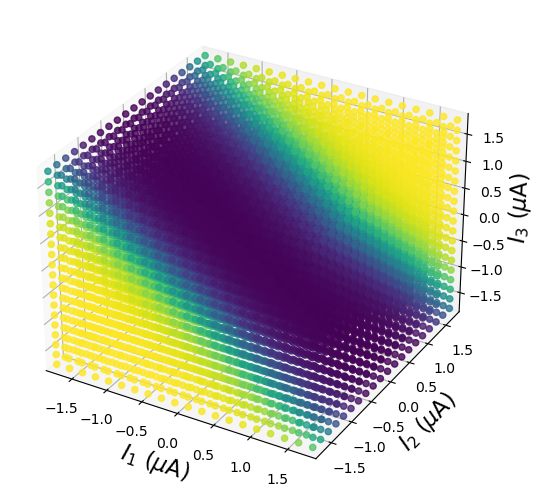

In [10]:
fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

scat = ax.scatter(X_expt_orig[:, 0], 
            X_expt_orig[:, 1],
            X_expt_orig[:, 2], marker='o', c=p_true, s=20, alpha=0.8, vmin=0, vmax=1)

In [11]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    return p_empirical

In [12]:
def fisher_info(x, w, t):
    # x : current levels, c x d
    # w : site weights, n x d
    # y : empirical probability for each current level, c
    # t: number of trials for each current level, c
    
    p_model = jnp.clip(activation_probs(x, w), a_min=1e-5, a_max=1-1e-5) # c
    I_p = jnp.diag(t / (p_model * (1 - p_model)))   # c x c
    J = jax.jacfwd(activation_probs, argnums=1)(x, w).reshape((len(x), w.shape[0]*w.shape[1]))
    I_w = jnp.dot(jnp.dot(J.T, I_p), J) / len(x)
    
    loss = jnp.trace(J @ (jnp.linalg.inv(I_w) @ J.T))
    return loss

In [13]:
def optimize_fisher(x, w, t_prev, t, reg=0, step_size=0.001, n_steps=100, reltol=-np.inf, T_budget=5000, step_cnt_decrement=5):

    optimizer = optax.adamw(step_size)
    opt_state = optimizer.init(t)

    @jax.jit
    def update(x, w, t_prev, t):
        fisher_lambda = lambda t, x, w, t_prev: fisher_info(x, w, t_prev + jnp.absolute(t))  + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)
        grads = jax.grad(fisher_lambda)(t, x, w, t_prev)

        return grads
    
    losses = []
    for step in range(n_steps):
        grads = update(x, w, t_prev, t)
        updates, opt_state = optimizer.update(grads, opt_state, params=t)
        t = optax.apply_updates(t, updates)

        losses += [[fisher_info(x, w, t_prev + jnp.absolute(t)), 
                    jnp.sum(jnp.absolute(t)),
                    fisher_info(x, w, t_prev + jnp.absolute(t)) + reg * jnp.absolute(jnp.sum(jnp.absolute(t)) - T_budget)]]

    return np.array(losses), t

In [14]:
def get_performance_AL(X, w_meas, p_true):
    probs_pred = activation_probs(X, w_meas)
    RMSE = jnp.sqrt(jnp.sum((probs_pred - p_true)**2) / len(X))

    return RMSE

Restart 1


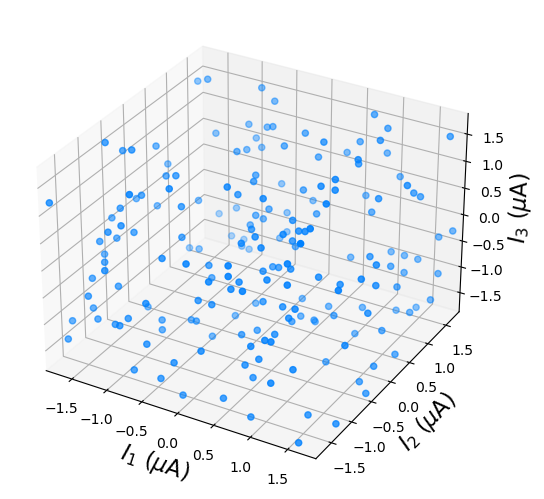

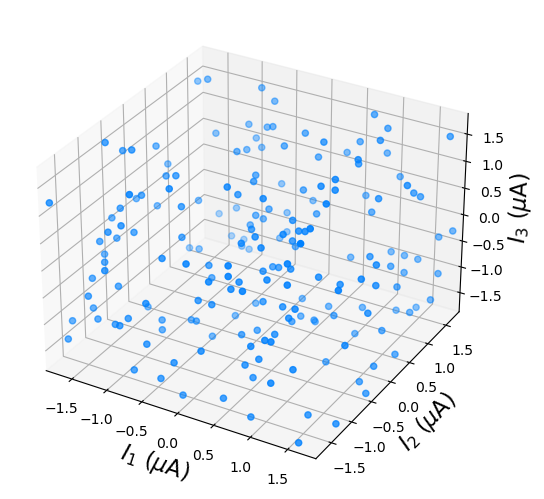

7367.407
0.9643121 262.92764
0.96458966 260.88232
[[-5.7975173 -2.650607  -3.6381261 -2.5757267]
 [-6.0636435  2.5039792  3.5926116  2.732905 ]]
[[-5.7975173 -2.650607  -3.6381261 -2.5757267]
 [-6.0636435  2.5039792  3.5926116  2.732905 ]]
0.036132574 0.036132574


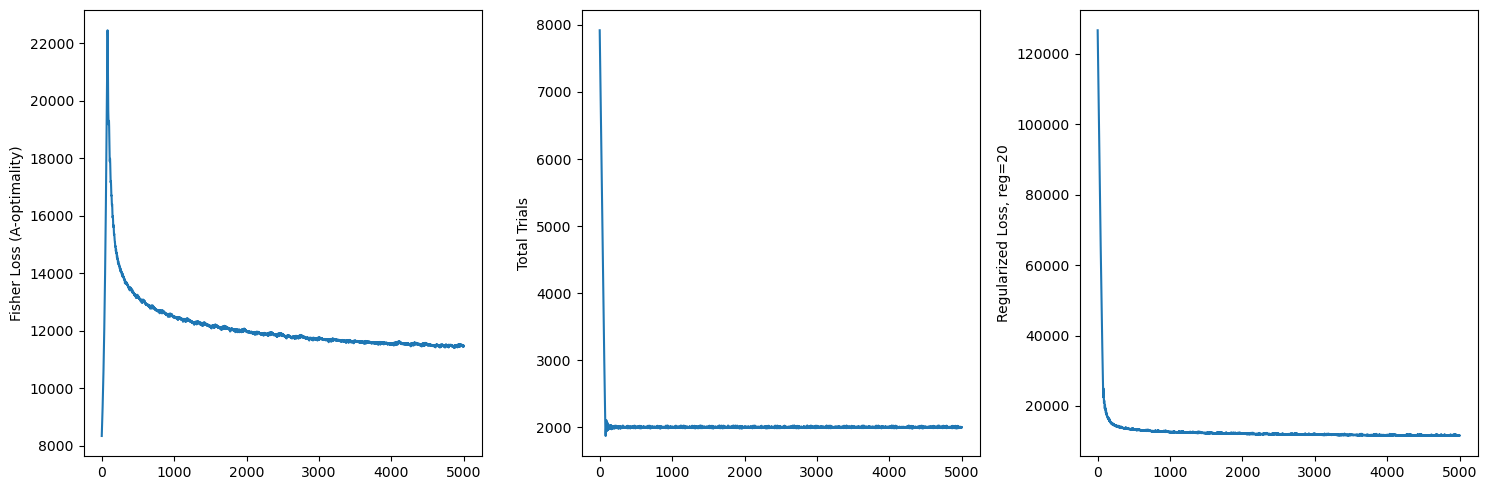

1909.0


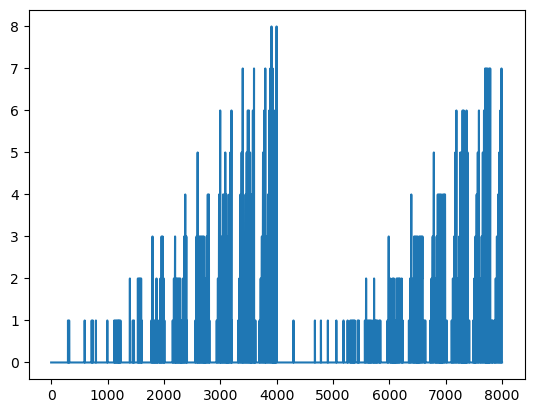

2000.0


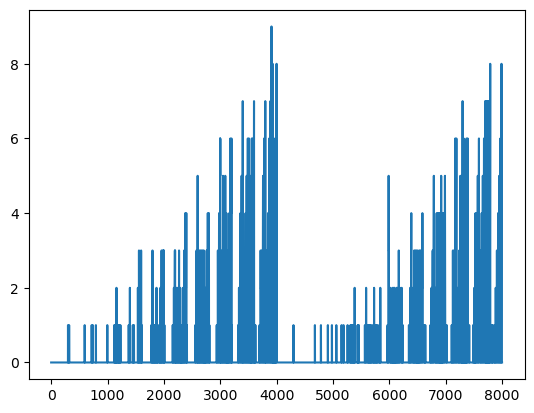

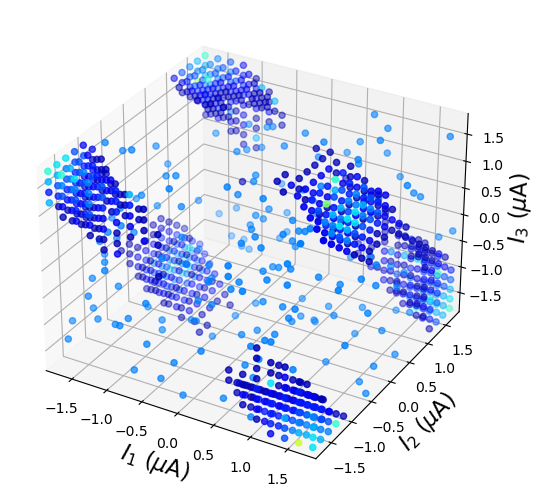

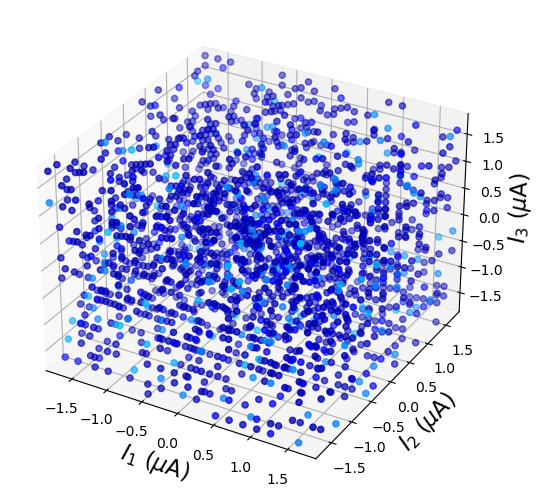

19431.54
0.92650974 1428.0283
0.92657596 1426.7422
[[-5.668737  -2.537839  -3.4450169 -2.7846265]
 [-5.5277333  2.3398917  3.1216269  2.5950363]]
22781.402
0.96292734 844.5665
0.96297467 843.48914
[[-5.5445065 -2.5079362 -3.3533602 -2.712402 ]
 [-5.7205625  2.4360034  3.2866967  2.7364566]]
0.0118566295 0.009501371


KeyboardInterrupt: 

In [16]:
%matplotlib inline

total_budget = 10000
num_iters = 5
budget = int(total_budget / num_iters)
reg = 20    #np.flip(np.logspace(-5, 3, 100000, base=2))
num_restarts = 1
# w_step_size = 1
l2_reg = 0
T_step_size = 0.01 #0.01
T_n_steps = 5000

init_size = 200
init_trials = 5

performance_stack = []
performance_stack_random = []
num_samples_stack = []

for restart in range(num_restarts):
    print('Restart', restart + 1)
    # Initialize amplitudes
    init_inds = np.random.choice(len(X), replace=False, size=init_size)

    # Initialize trials
    T_prev = jnp.zeros(len(X_expt_orig))
    T_prev = T_prev.at[init_inds].set(init_trials)
    T_prev_random = jnp.copy(T_prev)

    p_empirical = jnp.array(sample_spikes(p_true, T_prev))
    p_empirical_random = jnp.copy(p_empirical)

    performances = []
    performances_random = []
    num_samples = []

    w_inits = []
    for m in ms:
        w_init = jnp.array(np.random.normal(size=(m, X.shape[1])))
        w_inits.append(w_init)

    w_inits_random = copy(w_inits)
    cnt = 0

    while True:
        num_samples.append(np.sum(np.absolute(np.array(T_prev)).astype(int)))
        sampled_inds = np.where(np.absolute(np.array(T_prev)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
        #             X_expt_orig[sampled_inds, 1],
        #             X_expt_orig[sampled_inds, 2], marker='o', c=p_empirical[sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)
        scat = ax.scatter(X_expt_orig[sampled_inds, 0], 
                    X_expt_orig[sampled_inds, 1],
                    X_expt_orig[sampled_inds, 2], marker='o', c=T_prev[sampled_inds], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        sampled_inds_random = np.where(np.absolute(np.array(T_prev_random)).astype(int) > 0)[0]

        fig = plt.figure()
        fig.clear()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
        plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
        plt.xlim(-1.8, 1.8)
        plt.ylim(-1.8, 1.8)
        ax.set_zlim(-1.8, 1.8)
        ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

        # scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
        #             X_expt_orig[sampled_inds_random , 1],
        #             X_expt_orig[sampled_inds_random , 2], marker='o', c=p_empirical_random[sampled_inds_random], s=20, alpha=0.8, vmin=0, vmax=1)

        scat = ax.scatter(X_expt_orig[sampled_inds_random , 0], 
            X_expt_orig[sampled_inds_random , 1],
            X_expt_orig[sampled_inds_random , 2], marker='o', c=T_prev_random[sampled_inds_random], s=20, cmap=cm.jet, vmin=0, vmax=20)

        plt.show()

        w_final, w_inits =  fit_surface_McF(X[sampled_inds], p_empirical[sampled_inds], T_prev[sampled_inds], 
                                            w_inits, R2_thresh=R2_thresh, 
                                            l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=False)
        
        print(w_final)

        if cnt == 0:
            T_new_init = jnp.zeros(len(T_prev)) + 1
            w_final_random = jnp.copy(w_final)
        else:
            T_new_init = t_final
            w_final_random, w_inits_random =  fit_surface_McF(X[sampled_inds_random], p_empirical_random[sampled_inds_random], T_prev_random[sampled_inds_random], 
                                            w_inits_random, R2_thresh=R2_thresh, 
                                            l2_reg=l2_reg, w_step_size=w_step_size, n_steps=n_steps, plot=False)
        print(w_final_random)

        performance = get_performance_AL(X, w_final, p_true)
        performances.append(performance)
        
        performance_random = get_performance_AL(X, w_final_random, p_true)
        performances_random.append(performance_random)

        print(performance, performance_random)
        # print('\n')

        if cnt >= num_iters:
            break
        
        losses, t_final = optimize_fisher(X, w_final, T_prev, T_new_init, reg=reg, step_size=T_step_size, n_steps=T_n_steps, T_budget=budget)
        
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].plot(losses[:, 0])
        axs[0].set_ylabel('Fisher Loss (A-optimality)')
        axs[1].plot(losses[:, 1])
        axs[1].set_ylabel('Total Trials')
        axs[2].plot(losses[:, 2])
        axs[2].set_ylabel('Regularized Loss, reg=' + str(reg))

        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        plt.show()

        T_new = jnp.round(jnp.absolute(t_final), 0)#(t_final + T_new_explore), 0)
        print(jnp.sum(T_new))
        plt.figure()
        plt.plot(T_new)
        plt.show()

        if jnp.sum(T_new) < budget:
            random_extra = np.random.choice(len(X), size=int(budget - jnp.sum(T_new)), 
                                            p=np.array(jnp.absolute(t_final))/np.sum(np.array(jnp.absolute(t_final))))
            T_new_extra = jnp.array(np.bincount(random_extra, minlength=len(X))).astype(int)
            T_new = T_new + T_new_extra
            
            print(jnp.sum(T_new))
            plt.figure()
            plt.plot(T_new)
            plt.show()

        p_new = jnp.array(sample_spikes(p_true, T_new))

        p_tmp = (p_new * T_new + p_empirical * T_prev) / (T_prev + T_new)
        T_tmp = T_prev + T_new
        p_tmp = p_tmp.at[jnp.isnan(p_tmp)].set(0.5)

        p_empirical = p_tmp
        T_prev = T_tmp

        # print(jnp.sum(T_tmp))

        random_draws = np.random.choice(len(X), size=int(jnp.sum(T_new)))
        T_new_random = jnp.array(np.bincount(random_draws, minlength=len(X))).astype(int)
        p_new_random = jnp.array(sample_spikes(p_true, T_new_random))
        
        p_tmp_random = (p_new_random * T_new_random + p_empirical_random * T_prev_random) / (T_prev_random + T_new_random)
        T_tmp_random = T_prev_random + T_new_random
        p_tmp_random = p_tmp_random.at[jnp.isnan(p_tmp_random)].set(0.5)

        p_empirical_random = p_tmp_random
        T_prev_random = T_tmp_random

        cnt += 1

        # input()
    
    performance_stack.append(performances)
    performance_stack_random.append(performances_random)
    num_samples_stack.append(num_samples)

In [ ]:
savemat('sampling_map_p3_n296.mat', {'X': np.array(X_expt_orig),
                                     'p_empirical': np.array(p_empirical),
                                     'sampled_inds': np.array(sampled_inds), 
                                     'T': np.array(T_prev),
                                     'init_inds': init_inds})

In [ ]:
%matplotlib ipympl

fig = plt.figure()
fig.clear()
ax = Axes3D(fig, auto_add_to_figure=False)
ax.view_init(elev=16., azim=-50)
fig.add_axes(ax)
plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
plt.xlim(-1.8, 1.8)
plt.ylim(-1.8, 1.8)
ax.set_zlim(-1.8, 1.8)
ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

T_prev_tmp = T_prev.at[init_inds].set(T_prev[init_inds]-init_trials)
sampled_inds_tmp = np.where(np.absolute(np.array(T_prev_tmp)).astype(int) > 0)[0]
scat = ax.scatter(X_expt_orig[sampled_inds_tmp, 0], 
            X_expt_orig[sampled_inds_tmp, 1],
            X_expt_orig[sampled_inds_tmp, 2], marker='o', c=T_prev_tmp[sampled_inds_tmp], s=20, cmap=cm.jet, vmin=0, vmax=20)

plt.show()

In [ ]:
# savemat('performances_5step_p2_n259_adamw.mat', {'performance_stack': np.array(performance_stack),
#                                                 'performance_stack_random': np.array(performance_stack_random)})

In [ ]:
%matplotlib inline

plt.figure(figsize=(10, 8))
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack), 0), 
             yerr=np.std(np.array(performance_stack), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Active Learning', c='tab:blue', alpha=0.3)
plt.errorbar(np.mean(np.array(num_samples_stack), axis=0), np.mean(np.array(performance_stack_random), 0), 
             yerr=np.std(np.array(performance_stack_random), axis=0), fmt='o', ls='-', linewidth=4, elinewidth=2, label='Random Baseline', c='tab:orange', alpha=0.3)

# plt.yscale('log')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Trials Sampled', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)
# plt.ylim(0.36, 0.4)

# plt.savefig('performances_5step_p2_n259_adamw.png', dpi=300)

In [ ]:
w_true_t, w_true_nt

In [ ]:
all_combos = fitting.all_combos(np.arange(len(cells)))
ws_full = []
for i in range(len(cells)):
    ws_full.append(np.array(ws[i]))

ws_active = []
ws_active += [np.array(w_final_t)]
ws_active += [np.array(w_final_nt)]

for j in all_combos:
    combo = np.array(j)
    if len(combo) != 0 and len(combo) != len(cells):
        targets = combo
        selectivities_full.append(fitting.selectivity_triplet(ws_full, targets))
        selectivities_active.append(fitting.selectivity_triplet(ws_active, targets))
        datasets.append((dataset, wnoise, estim, p, cells, cells[targets]))

In [ ]:
selectivities_full, selectivities_active

In [ ]:
datasets

In [ ]:
x = np.array(selectivities_full)[:, 1]
y = np.vstack((np.array(selectivities_full)[:, 0], np.array(selectivities_active)[:, 0])).T

lines = []
for i, j in zip(x, y):
    pair = [(i, j[0]), (i, j[1])]
    lines.append(pair)

linecoll = matcoll.LineCollection(lines, colors='k')

fig, ax = plt.subplots()
ax.plot(x, [i for (i,j) in y], 's', c='tab:blue', markersize = 10, alpha=0.8, label='Full Dataset')
ax.plot(x, [j for (i,j) in y], 'o', c='tab:red', markersize = 10, alpha=0.8, label='Subsampled Dataset')
ax.add_collection(linecoll)
ax.plot(np.linspace(-0.01, 1.01, 100), np.linspace(-0.01, 1.01, 100), linestyle='--', c='k')
ax.set_xlabel('Single-Electrode Selectivity', fontsize=22)
ax.set_ylabel('Triplet Selectivity', fontsize=22)
ax.tick_params('both', labelsize=18)
ax.legend(fontsize=16)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.savefig('fig2_NER.png', dpi=300)

In [ ]:
np.save('selectivities_full.npy', np.array(selectivities_full))
np.save('selectivities_active.npy', np.array(selectivities_active))
np.save('datasets.npy', np.array(datasets, dtype=object))